In [ ]:
# Import thư viện cần thiết
from pdf2image import convert_from_path
import os
import re
import unicodedata
from collections import defaultdict
import difflib
import pandas as pd
from PIL import Image
import pytesseract
import cv2
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

1. Chuyển file PDF sang các file ảnh

In [ ]:
# Xử lí PDF 1 thành hình ảnh dạng png từ trang 203 đến trang 395 (theo id)
pdf_file = "../data/pdf/PDF1.pdf"
output_folder = "../image/PDF1"


images = convert_from_path(
    pdf_file,
    first_page=203,
    last_page=395
)

for page_num, img in enumerate(images, start=203):
    filename = f"PDF1-{page_num}.png"
    save_path = os.path.join(output_folder, filename)
    img.save(save_path, "PNG")


In [ ]:
# Xử lí PDF 3 thành hình ảnh dạng png từ trang 12 đến trang 118 (theo id)
pdf_file = "../data/pdf/PDF3.pdf"
output_folder = "../image/PDF3"

os.makedirs(output_folder, exist_ok=True)

start_page = 12
end_page = 118

images = convert_from_path(pdf_file, first_page=start_page, last_page=end_page)

for page_num, img in zip(range(start_page, end_page + 1), images):
    page_str = f"{page_num:03d}"           
    filename = f"PDF3-{page_str}.png"
    save_path = os.path.join(output_folder, filename)

    img.save(save_path, "PNG")

2. Tiền xử lí ảnh trước khi OCR

 Tìm thấy 47 file ảnh (từ 250 đến 296) cần xử lý.
 Tiền xử lý ảnh mẫu để hiển thị: PDF1-250.png


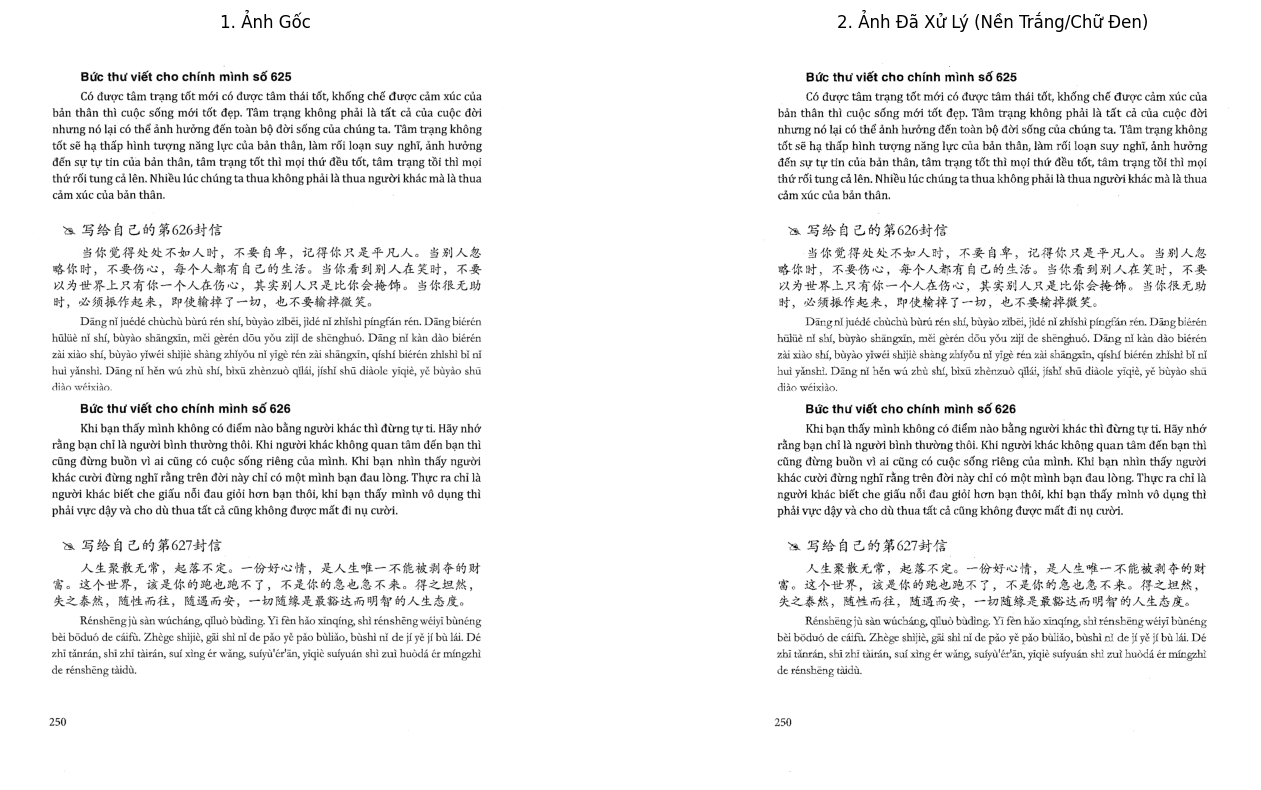

----------------------------------------------------------------------
  Xử lý và lưu 47 file ảnh
 Xử lý 47 file ảnh xong. Các file đã lưu vào thư mục: ../image\PDF1_processed


In [ ]:
INPUT_ROOT = '../data/image'
INPUT_SUBDIR = 'PDF1'
INPUT_DIR = os.path.join(INPUT_ROOT, INPUT_SUBDIR)
OUTPUT_SUBDIR = '../data/preprocessing_data' # Đổi tên thư mục để tránh ghi đè
OUTPUT_DIR = os.path.join(INPUT_ROOT, OUTPUT_SUBDIR)
START_PAGE = 203
END_PAGE = 250

os.makedirs(OUTPUT_DIR)


# Lọc file trong phạm vi trang 
target_files = []
try:
    all_image_files = os.listdir(INPUT_DIR)
    pattern = re.compile(r'PDF1-(\d+)\.png$', re.IGNORECASE)
    
    for file_name in all_image_files:
        match = pattern.match(file_name)
        if match:
            page_number = int(match.group(1))
            if START_PAGE <= page_number <= END_PAGE:
                target_files.append(file_name)
                
except FileNotFoundError:
    print(f"Không tìm thấy thư mục đầu vào tại {INPUT_DIR}. ")
    
target_files.sort(key=lambda f: int(re.search(r'PDF1-(\d+)\.png$', f).group(1)))

print(f" Tìm thấy {len(target_files)} file ảnh (từ {START_PAGE} đến {END_PAGE}) cần xử lý.")


# Tiền xử lý ảnh OCR
def preprocess_for_ocr_enforce_white_bg(image_path):
    """
    Tiền xử lý nâng cao: Làm sắc nét, tăng tương phản, nhị phân hóa (Otsu), 
    khử nhiễu bằng Morphological Closing và đầu ra là NỀN TRẮNG/CHỮ ĐEN.
    """
    
    img = cv2.imread(image_path, cv2.IMREAD_COLOR) 
    if img is None:
        print(f"Không thể đọc ảnh tại {image_path}")
        return None, None
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Làm Sắc Nét (Sharpening)
    sharpen_kernel = np.array([[ 0, -1,  0],
                               [-1,  5, -1],
                               [ 0, -1,  0]])
    sharpened = cv2.filter2D(gray, -1, sharpen_kernel)

    # Tăng Tương Phản (Gamma Correction)
    gamma = 2.0 
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    contrasted = cv2.LUT(sharpened, table)
    
    # Phân Ngưỡng Nhị Phân (Tách Nền/Chữ)
    
    # TH1: NỀN TRẮNG / CHỮ ĐEN (THRESH_BINARY_INV)
    _, thresh_inverted = cv2.threshold(contrasted, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # TH2: NỀN ĐEN / CHỮ TRẮNG (THRESH_BINARY)
    _, thresh_normal = cv2.threshold(contrasted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Lựa chọn ảnh có nền trắng (nền chiếm ưu thế trong văn bản)
    # Ảnh có nền trắng sẽ có tổng số pixel trắng (255) lớn hơn đen (0) -> giá trị trung bình > 127
    if np.mean(thresh_inverted) > np.mean(thresh_normal):
        # thresh_inverted đã cho ra Nền Trắng / Chữ Đen (Định dạng mong muốn)
        binary_img = thresh_inverted
    else:
        # thresh_normal đã cho ra Nền Trắng / Chữ Đen (Ảnh gốc bị ngược màu)
        # Hoặc thresh_inverted cho ra Nền Đen / Chữ Trắng (Ảnh gốc xuôi màu)
        # Đảo ngược thresh_normal để có Nền Trắng / Chữ Đen
        binary_img = cv2.bitwise_not(thresh_normal)

    # Ép buộc về NỀN TRẮNG/CHỮ ĐEN để khử nhiễu

    if np.mean(binary_img) > 127:
        # Nền Trắng/Chữ Đen -> Đảo thành Nền Đen/Chữ Trắng (Tạm thời)
        img_for_denoise = cv2.bitwise_not(binary_img)
    else:
        img_for_denoise = binary_img
        
    # Khử Nhiễu Đốm Đen (Morphological Closing)
    # Dùng phép Đóng (Closing) để lấp đầy các đốm đen (nhiễu) trên nền trắng
    kernel = np.ones((2, 2), np.uint8) 
    denoised_closed = cv2.morphologyEx(img_for_denoise, cv2.MORPH_CLOSE, kernel)
    
    # Đảo Ngược Lại (Reverse) để có Nền Trắng/Chữ Đen
    final_img = cv2.bitwise_not(denoised_closed)

    # Kiểm tra lần cuối: Nếu vẫn là nền đen (do ảnh có quá nhiều chi tiết) -> đảo lại
    if np.mean(final_img) < 127: 
         final_img = cv2.bitwise_not(final_img)
         
    return final_img, img

# Xử lý và hiển thị kết quả cho ảnh mẫu
# sample_file = 'PDF1-203.png'

# if sample_file in target_files:
#     sample_path = os.path.join(INPUT_DIR, sample_file)
#     print(f" Tiền xử lý ảnh mẫu để hiển thị: {sample_file}")
#     processed_sample, original_img = preprocess_for_ocr_enforce_white_bg(sample_path)
    
#     if processed_sample is not None:
#         output_path = os.path.join(OUTPUT_DIR, f"processed_{sample_file}")
#         cv2.imwrite(output_path, processed_sample)
        
#         original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
#         plt.figure(figsize=(16, 8))
        
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_img_rgb)
#         plt.title('1. Ảnh Gốc ')
#         plt.axis('off')
        
#         plt.subplot(1, 2, 2)
#         plt.imshow(processed_sample, cmap='gray') 
#         plt.title('2. Ảnh Đã Xử Lý (Nền Trắng/Chữ Đen)')
#         plt.axis('off')
        
#         plt.tight_layout()
#         plt.show()
    
#     print("-" * 70)
# else:
#     print(f" Cảnh báo: Không tìm thấy file mẫu '{sample_file}' trong thư mục đã lọc.")

print(f"Xử lý và lưu {len(target_files)} file ảnh")
count = 0
for file_name in target_files:
    full_path = os.path.join(INPUT_DIR, file_name)
    processed_img, _ = preprocess_for_ocr_enforce_white_bg(full_path)
    
    if processed_img is not None:
        output_file_name = f"processed_{file_name}"
        output_path = os.path.join(OUTPUT_DIR, output_file_name)
        cv2.imwrite(output_path, processed_img)
        count += 1

print(f" Xử lý {count} file ảnh xong. Các file đã lưu vào thư mục: {OUTPUT_DIR}")

3. Xử lí các ảnh thông qua sử dụng Teseract OCR 

In [ ]:
TESSERACT_LANGS = 'chi_sim+chi_tra+vie'

def strip_accents(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

def is_chinese(text: str) -> bool:
    return any(
        '\u4e00' <= ch <= '\u9fff' or
        '\u3400' <= ch <= '\u4DBF'
        for ch in text
    )

def is_page_number_line(text: str) -> bool:
    return re.fullmatch(r"^\s*\d{1,4}\s*$", text) is not None

def looks_like_vietnamese(text: str) -> bool:
    norm = strip_accents(text).lower()
    tokens = re.findall(r"[a-z0-9]+", norm)

    def has_similar(target: str, thr: float) -> bool:
        for t in tokens:
            if difflib.SequenceMatcher(None, t, target).ratio() >= thr:
                return True
        return False

    return (
        has_similar("buc", 0.5) and
        has_similar("thu", 0.5) and
        has_similar("viet", 0.5) and
        has_similar("cho", 0.5) and
        has_similar("chinh", 0.5) and
        has_similar("minh", 0.5)
    )

def extract_id(text: str):
    def norm_digits(tok: str):
        tok = tok.strip()
        tok = tok.replace('O', '0').replace('o', '0')
        tok = tok.replace('I', '1').replace('l', '1')
        tok = tok.replace('|', '1').replace('!', '1')

        digits = "".join(re.findall(r"\d+", tok))
        if not digits or len(digits) < 3:
            return None, None
        return digits, None

    m_zh_full = re.search(
        r"写\s*给\s*自己\s*的\s*第\s*([0-9OoIl|!\s]{1,20})\s*封\s*信",
        text
    )
    if m_zh_full:
        id_val, _ = norm_digits(m_zh_full.group(1))
        if id_val:
            return id_val, 'ZH_FULL'

    norm = strip_accents(text).lower()
    m_vi_full = re.search(
        r"buc\s*thu\s*viet\s*cho\s*chinh\s*minh\s*(?:so|s0|s6|s)\s*([0-9OoIl|!\s]{1,20})",
        norm
    )
    if m_vi_full:
        id_val, _ = norm_digits(m_vi_full.group(1))
        if id_val:
            return id_val, 'VI_FULL'

    m_zh_anchor = re.search(r"第\s*([0-9OoIl|!\s]{1,20})", text)
    if m_zh_anchor:
        id_val, _ = norm_digits(m_zh_anchor.group(1))
        if id_val:
            return id_val, 'ZH_ANCHOR'

    m_vi_anchor = re.search(
        r"(?:\bso\b|\bs0\b|\bs6\b|s[0o6])\s*([0-9OoIl|!\s]{1,20})",
        norm
    )
    if m_vi_anchor:
        id_val, _ = norm_digits(m_vi_anchor.group(1))
        if id_val:
            return id_val, 'VI_ANCHOR'

    return None, None

# OCR TESSERACT
def tesseract_ocr(img_path: str, lang: str = TESSERACT_LANGS):
    try:
        text_raw = pytesseract.image_to_string(
            Image.open(img_path),
            lang=lang,
            config='--psm 3'
        )
        return [l.strip() for l in text_raw.split('\n') if l.strip()]
    except Exception as e:
        print(f"Lỗi OCR {img_path}: {e}")
        return []

# Parse ảnh -> Data
DATA_MAP = defaultdict(lambda: {"src": [], "tgt": [], "vi_started": False})
STATE = {"current_id": None, "mode": None, "pending_src": []}

def process_image_to_data(img_path: str, data_map, state):
    lines = tesseract_ocr(img_path)

    current_id = state["current_id"]
    mode = state["mode"]
    pending_src = state["pending_src"]

    for text in lines:
        if is_page_number_line(text):
            continue

        found_id, id_type = extract_id(text)

        if found_id:
            current_id = found_id
            _ = data_map[current_id]

            if pending_src:
                data_map[current_id]["src"].extend(pending_src)
                pending_src.clear()

            if id_type in ('ZH_FULL', 'ZH_ANCHOR'):
                mode = "zh"
                if not data_map[current_id]["src"]:
                    data_map[current_id]["src"].append(
                        f"写 给 自己 的 第 {current_id} 封 信"
                    )

            elif id_type in ('VI_FULL', 'VI_ANCHOR') or looks_like_vietnamese(text):
                mode = "vi"
                if not data_map[current_id]["vi_started"]:
                    data_map[current_id]["tgt"] = []
                    data_map[current_id]["vi_started"] = True
                    data_map[current_id]["tgt"].append(
                        f"Bức thư viết cho chính mình số {current_id}"
                    )
            continue

        if current_id is None:
            if is_chinese(text):
                pending_src.append(text)
            continue

        if is_chinese(text):
            data_map[current_id]["src"].append(text)
        else:
            if mode == "vi":
                data_map[current_id]["tgt"].append(text)

    state["current_id"] = current_id
    state["mode"] = mode
    state["pending_src"] = pending_src



Đang xử lý: ../image/PDF1_processed\processed_PDF1-250.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-251.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-252.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-253.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-254.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-255.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-256.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-257.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-258.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-259.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-260.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-261.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-262.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-263.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-264.png...
Đang xử lý: ../image/PDF1_processed\processed_PDF1-265.png...
Đang xử 

In [ ]:
# Main process
IMG_DIR = "../data/image/preprocessing_data"
OUT_DIR = "../output"
os.makedirs(OUT_DIR, exist_ok=True)

START_PAGE = 203
END_PAGE = 250

DATA_MAP.clear()
STATE = {"current_id": None, "mode": None, "pending_src": []}

for p in range(START_PAGE, END_PAGE + 1):
    img_path = os.path.join(IMG_DIR, f"processed_PDF1-{p}.png")
    if os.path.exists(img_path):
        print(f"Đang xử lý: {img_path}...")
        process_image_to_data(img_path, DATA_MAP, STATE)

rows = []
for sid, v in DATA_MAP.items():
    src = " ".join(v["src"]).strip()
    tgt = " ".join(v["tgt"]).strip()
    if src or tgt:
        rows.append({
            "src_id": sid,
            "src_lang": src,
            "tgt_lang": tgt
        })

df = pd.DataFrame(rows)

# Lọc ID 
ID_START = 501
ID_END = 625

df = df[df['src_id'].str.isdigit()].copy()
df['src_id_int'] = df['src_id'].astype(int)
df = df[(df['src_id_int'] >= ID_START) & (df['src_id_int'] <= ID_END)]
df = df.sort_values('src_id_int').drop(columns=['src_id_int']).reset_index(drop=True)

# Xuất CSV
if not df.empty:
    min_id = df['src_id'].astype(int).min()
    max_id = df['src_id'].astype(int).max()
else:
    min_id = max_id = 0

out_csv = os.path.join(OUT_DIR, f"PDF1_{min_id}_{max_id}.csv")
df.to_csv(out_csv, index=False, encoding="utf-8-sig")
print("Saved:", out_csv)

In [ ]:
df.head()

4. Hậu xử lí OCR